# Herbarium-Field Dataset Pre-processing Pipeline

## 1. Setup and Configuration
Import required libraries and set up data paths


In [38]:
# Colab: minimal deps
import os, sys, json, random, shutil, hashlib
from pathlib import Path
from typing import Dict, Tuple, List

import numpy as np
import pandas as pd

# Reproducibility
SEED = 42
random.seed(SEED); np.random.seed(SEED)

# === CHANGE THIS to where you put the dataset in Colab ===
# Example if you unzipped to /content/data
DATA_ROOT = Path(r"D:\AML\AML dataset\Herbarium_Field dataset\AML_project_herbarium_dataset")       

LIST_DIR  = DATA_ROOT / "list"
TRAIN_DIR = DATA_ROOT / "train"
TEST_DIR  = DATA_ROOT / "test"

# TXT files expected
SPECIES_LIST_TXT       = LIST_DIR / "species_list.txt"
TRAIN_LIST_TXT         = LIST_DIR / "train.txt"
TEST_LIST_TXT          = LIST_DIR / "test.txt"
GROUNDTRUTH_TXT        = LIST_DIR / "groundtruth.txt"   # labels for test (use ONLY for evaluation)
CLASS_WITH_PAIRS_TXT   = LIST_DIR / "class_with_pairs.txt"      # optional
CLASS_WITHOUT_PAIRS_TXT= LIST_DIR / "class_without_pairs.txt"   # optional

# Output dir for processed CSVs / artifacts
OUT_DIR = DATA_ROOT / "processed"
OUT_DIR.mkdir(parents=True, exist_ok=True)
print("Using DATA_ROOT =", DATA_ROOT)


Using DATA_ROOT = D:\AML\AML dataset\Herbarium_Field dataset\AML_project_herbarium_dataset


## 2. Helper Functions
Define utility functions for parsing files and verifying paths


In [15]:
def read_lines(fp: Path) -> List[str]:
    with open(fp, "r", encoding="utf-8") as f:
        return [ln.strip() for ln in f if ln.strip()]

def parse_species_list(fp: Path) -> pd.DataFrame:
    """
    Expected patterns per line:
        <class_id>; <species name with spaces...>
        or
        <class_id> <species name with spaces...>
    """
    rows = []
    for ln in read_lines(fp):
        # Handle semicolon separator
        if ';' in ln:
            parts = ln.split(';', 1)
            if len(parts) == 2 and parts[0].strip().isdigit():
                cid = int(parts[0].strip())
                name = parts[1].strip()
                rows.append({"class_id": cid, "species_name": name})
                continue
        
        # Fallback to space-separated format
        parts = ln.split()
        cid = None
        for i, tok in enumerate(parts):
            if tok.isdigit():
                cid = int(tok)
                name = " ".join(parts[i+1:]).strip()
                break
        if cid is None:
            raise ValueError(f"Could not parse class_id from line: {ln}")
        rows.append({"class_id": cid, "species_name": name})
    
    df = pd.DataFrame(rows).sort_values("class_id").reset_index(drop=True)
    # Build contiguous label_idx 0..N-1 (stable mapping saved to disk)
    df["label_idx"] = np.arange(len(df), dtype=int)
    return df

def parse_annot_line(ln: str) -> Tuple[str, int]:
    """
    Parse a train/test line. Common formats observed:
      1) "<relative_path> <class_id>"
      2) "<class_id> <relative_path>"
    For TEST, sometimes there is no class_id; those will be resolved via groundtruth later.
    """
    parts = ln.split()
    if len(parts) == 2:
        a, b = parts
        if a.isdigit() and not b.isdigit():
            return b, int(a)   # "id path"
        if b.isdigit() and not a.isdigit():
            return a, int(b)   # "path id"
        # If both look non-digit or both digit, we can't trust it
        raise ValueError(f"Ambiguous line (2 tokens): {ln}")
    elif len(parts) == 1:
        # Likely test without labels
        return parts[0], None
    else:
        raise ValueError(f"Unexpected format: {ln}")

def infer_domain_from_path(p: str) -> str:
    p_low = p.lower()
    if "herbarium" in p_low:
        return "herbarium"
    if "field" in p_low or "photo" in p_low:
        return "field"
    # fallback: test dir is field per assignment
    if "/test/" in ("/" + p.replace("\\","/") + "/"):
        return "field"
    return "unknown"

def verify_paths(df: pd.DataFrame, base: Path) -> pd.DataFrame:
    abs_paths = []
    exists_flags = []
    for rel in df["rel_path"]:
        abs_p = base / rel
        abs_paths.append(str(abs_p))
        exists_flags.append(abs_p.exists())
    df["abs_path"] = abs_paths
    df["exists"]   = exists_flags
    return df


## 3. Parse Species List
Load species list and create label index mapping (class_id → label_idx)


In [16]:
species_df = parse_species_list(SPECIES_LIST_TXT)
species_df.to_csv(OUT_DIR / "species_mapping.csv", index=False)
print(species_df.head(3))
print(f"Species/classes: {len(species_df)}")


   class_id               species_name  label_idx
0     12254  Anacardium occidentale L.          0
1     12518        Mangifera indica L.          1
2     12910         Spondias mombin L.          2
Species/classes: 100


## 4. Load Training Data
Parse training list, merge with species metadata, and verify file paths


In [17]:
# Read train list
train_rows = []
for ln in read_lines(TRAIN_LIST_TXT):
    rel, cid = parse_annot_line(ln)
    if cid is None:
        raise ValueError(f"Train list line has no class id: {ln}")
    train_rows.append({"rel_path": rel, "class_id": int(cid)})

train_df = pd.DataFrame(train_rows)
# Attach label_idx and species_name
train_df = train_df.merge(species_df[["class_id","label_idx","species_name"]], on="class_id", how="left")
assert train_df["label_idx"].notnull().all(), "Some class_ids in train.txt not found in species_list.txt"

# Domain flag
train_df["domain"] = train_df["rel_path"].apply(infer_domain_from_path)

# Verify files exist
train_df = verify_paths(train_df, DATA_ROOT)
missing = train_df.loc[~train_df["exists"]]
if len(missing) > 0:
    print("WARNING: Missing train files:", len(missing))
    display(missing.head(10))
else:
    print("All train files exist.")

# Quick stats
print(train_df["domain"].value_counts(dropna=False))
print("Train samples:", len(train_df))
train_df.head(3)


All train files exist.
domain
herbarium    3700
field        1044
Name: count, dtype: int64
Train samples: 4744


,rel_path,class_id,label_idx,species_name,domain,abs_path,exists
0,train/photo/106461/154340.jpg,106461,20,Costus scaber Ruiz Pav.,field,D:\AML\AML dataset\Herbarium_Field dataset\AML...,True
1,train/photo/106461/154115.jpg,106461,20,Costus scaber Ruiz Pav.,field,D:\AML\AML dataset\Herbarium_Field dataset\AML...,True
2,train/photo/106461/154345.jpg,106461,20,Costus scaber Ruiz Pav.,field,D:\AML\AML dataset\Herbarium_Field dataset\AML...,True


## 5. Load Test Data and Ground Truth
Parse test list and ground truth labels (for evaluation only)


In [18]:
# Test list: often no labels inside test.txt
test_rows = []
for ln in read_lines(TEST_LIST_TXT):
    rel, maybe_cid = parse_annot_line(ln)  # may be None
    test_rows.append({"rel_path": rel, "class_id": maybe_cid})

test_df = pd.DataFrame(test_rows)
test_df["domain"] = "field"  # per assignment
test_df = verify_paths(test_df, DATA_ROOT)

missing_t = test_df.loc[~test_df["exists"]]
if len(missing_t) > 0:
    print("WARNING: Missing test files:", len(missing_t))
    display(missing_t.head(10))
else:
    print("All test files exist.")
print("Test samples:", len(test_df))

# Optional: load groundtruth (DO NOT USE in training)
gt_rows = []
for ln in read_lines(GROUNDTRUTH_TXT):
    rel, cid = parse_annot_line(ln)
    if cid is None:
        raise ValueError(f"groundtruth needs class id: {ln}")
    gt_rows.append({"rel_path": rel, "class_id": int(cid)})

gt_df = pd.DataFrame(gt_rows)
gt_df = gt_df.merge(species_df[["class_id","label_idx","species_name"]], on="class_id", how="left")
assert gt_df["label_idx"].notnull().all(), "Some groundtruth class_ids not in species_list.txt"

# Merge labels onto test_df only for *evaluation scripts* later
test_with_labels_df = test_df.merge(gt_df[["rel_path","class_id","label_idx","species_name"]],
                                    on="rel_path", how="left", suffixes=("", "_gt"))


All test files exist.
Test samples: 207


## 6. Train/Validation Split
Stratified split ensuring all classes are represented in validation set


In [19]:
VAL_FRAC = 0.2  # 20% for validation

rng = np.random.RandomState(SEED)
def stratified_split(df: pd.DataFrame, label_col="label_idx", val_frac=0.2, seed=42):
    val_indices = []
    for lbl, grp in df.groupby(label_col, sort=False):
        n = len(grp)
        k = max(1, int(round(val_frac * n)))
        idx = grp.sample(n=k, random_state=seed, replace=False).index.tolist()
        val_indices.extend(idx)
    mask = df.index.isin(val_indices)
    val_df = df.loc[mask].copy()
    trn_df = df.loc[~mask].copy()
    return trn_df, val_df

train_split_df, val_split_df = stratified_split(train_df, label_col="label_idx", val_frac=VAL_FRAC, seed=SEED)

print("Train split:", len(train_split_df), " Val split:", len(val_split_df))
print("Val class coverage:", val_split_df["label_idx"].nunique(), "/", train_df["label_idx"].nunique())


Train split: 3796  Val split: 948
Val class coverage: 100 / 100


## 7. Save Processed CSV Files
Export train, validation, test, and species mapping files


In [20]:
# Minimal columns you actually need for loaders
cols = ["rel_path","abs_path","class_id","label_idx","species_name","domain"]

train_split_df[cols].to_csv(OUT_DIR / "train.csv", index=False)
val_split_df[cols].to_csv(OUT_DIR / "val.csv", index=False)
test_df[["rel_path","abs_path","domain"]].to_csv(OUT_DIR / "test.csv", index=False)

# Strictly for evaluation scripts later (keep separate so you don't “accidentally” use during training)
test_with_labels_df[["rel_path","abs_path","class_id","label_idx","species_name","domain"]].to_csv(
    OUT_DIR / "test_with_groundtruth.csv", index=False
)

# Persist the mapping you used (critical for reproducibility)
species_df.to_csv(OUT_DIR / "species_mapping.csv", index=False)

print("Wrote:")
for p in ["train.csv","val.csv","test.csv","test_with_groundtruth.csv","species_mapping.csv"]:
    print(" -", OUT_DIR / p)


Wrote:
 - D:\AML\AML dataset\Herbarium_Field dataset\AML_project_herbarium_dataset\processed\train.csv
 - D:\AML\AML dataset\Herbarium_Field dataset\AML_project_herbarium_dataset\processed\val.csv
 - D:\AML\AML dataset\Herbarium_Field dataset\AML_project_herbarium_dataset\processed\test.csv
 - D:\AML\AML dataset\Herbarium_Field dataset\AML_project_herbarium_dataset\processed\test_with_groundtruth.csv
 - D:\AML\AML dataset\Herbarium_Field dataset\AML_project_herbarium_dataset\processed\species_mapping.csv


## 8. Dataset Summary Statistics
Display sample counts, domain distribution, and class balance statistics


In [21]:
def summarize(df: pd.DataFrame, name: str):
    by_domain = df["domain"].value_counts(dropna=False).to_dict()
    print(f"\n{name}: {len(df)} samples")
    print("  Domain counts:", by_domain)
    
    # Only show class stats if label_idx exists (not for unlabeled test data)
    if "label_idx" in df.columns:
        by_class = df["label_idx"].value_counts().describe()
        print("  Class count stats:", by_class.to_dict())
    else:
        print("  Class count stats: N/A (unlabeled)")

summarize(train_split_df, "TRAIN")
summarize(val_split_df,   "VAL")
summarize(test_df,        "TEST (unlabeled)")



TRAIN: 3796 samples
  Domain counts: {'herbarium': 2855, 'field': 941}
  Class count stats: {'count': 100.0, 'mean': 37.96, 'std': 5.60648974606458, 'min': 18.0, '25%': 40.0, '50%': 40.0, '75%': 40.0, 'max': 40.0}

VAL: 948 samples
  Domain counts: {'herbarium': 845, 'field': 103}
  Class count stats: {'count': 100.0, 'mean': 9.48, 'std': 1.4458578942984162, 'min': 4.0, '25%': 10.0, '50%': 10.0, '75%': 10.0, 'max': 10.0}

TEST (unlabeled): 207 samples
  Domain counts: {'field': 207}
  Class count stats: N/A (unlabeled)


## 9. Species Pair Analysis - Part 1
Load lists of species with and without herbarium-field pairs


In [ ]:
# Load with-pairs and without-pairs lists
with_pairs_ids = [int(x) for x in read_lines(CLASS_WITH_PAIRS_TXT)]
without_pairs_ids = [int(x) for x in read_lines(CLASS_WITHOUT_PAIRS_TXT)]

with_pairs_df = species_df[species_df["class_id"].isin(with_pairs_ids)].copy()
with_pairs_df["has_pair"] = True
without_pairs_df = species_df[species_df["class_id"].isin(without_pairs_ids)].copy()
without_pairs_df["has_pair"] = False

# Merge the two dataframes
species_df = pd.concat([with_pairs_df, without_pairs_df])


## 9. Species Pair Analysis - Part 2
Count and display statistics of paired vs unpaired species


In [ ]:
total_species = len(species_df)
with_pairs = len(with_pairs_df)
without_pairs = len(without_pairs_df)

print(f"Total species in dataset     : {total_species}")
print(f"Species with herbarium-field pairs  : {with_pairs}")
print(f"Species with herbarium-only images  : {without_pairs}")

if with_pairs + without_pairs != total_species:
    print(f" Note: {total_species - (with_pairs + without_pairs)} species not listed in either file.")
else:
    print(" All species accounted for.")


Total species in dataset     : 100
Species with herbarium-field pairs  : 60
Species with herbarium-only images  : 40
✅ All species accounted for.


## 9. Species Pair Analysis - Part 3
Visualize distribution with pie chart


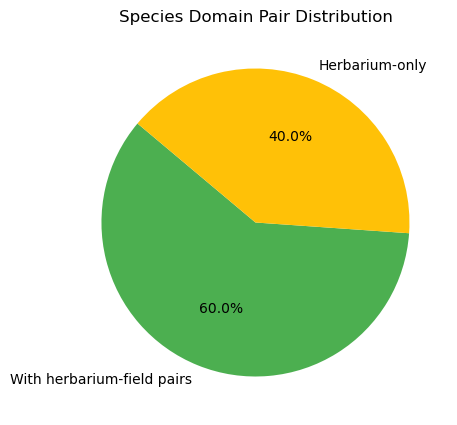

In [24]:
import matplotlib.pyplot as plt

labels = ["With herbarium-field pairs", "Herbarium-only"]
sizes = [with_pairs, without_pairs]
colors = ["#4CAF50", "#FFC107"]

plt.figure(figsize=(5,5))
plt.pie(sizes, labels=labels, autopct="%1.1f%%", startangle=140, colors=colors)
plt.title("Species Domain Pair Distribution")
plt.show()


## 9. Species Pair Analysis - Part 4
Generate comprehensive dataset summary report


In [25]:
total_species   = len(species_df)
num_with_pairs  = len(with_pairs_df)
num_without     = len(without_pairs_df)
unlisted_count  = total_species - (num_with_pairs + num_without)

print("Dataset Summary")
print("------------------")
print(f"Total species                : {total_species}")
print(f"Species with field-herbarium pairs : {num_with_pairs}")
print(f"Species without pairs (herbarium only): {num_without}")
if unlisted_count > 0:
    print(f" {unlisted_count} species are not listed in either file (possible oversight).")
else:
    print(" Every species is classified as paired or unpaired.")


Dataset Summary
------------------
Total species                : 100
Species with field-herbarium pairs : 60
Species without pairs (herbarium only): 40
 Every species is classified as paired or unpaired.


## 9. Species Pair Analysis - Part 5
Save paired and unpaired species lists to CSV files


In [ ]:
out_dir = DATA_ROOT / "processed"
out_dir.mkdir(exist_ok=True)

with_pairs_df.to_csv(out_dir / "species_with_pairs.csv", index=False)
without_pairs_df.to_csv(out_dir / "species_without_pairs.csv", index=False)

print(f"\nSaved detailed tables to:\n - {out_dir / 'species_with_pairs.csv'}\n - {out_dir / 'species_without_pairs.csv'}")



💾 Saved detailed tables to:
 - D:\AML\AML dataset\Herbarium_Field dataset\AML_project_herbarium_dataset\processed\species_with_pairs.csv
 - D:\AML\AML dataset\Herbarium_Field dataset\AML_project_herbarium_dataset\processed\species_without_pairs.csv


## 10. Image Quality Check - Part 1
Load CSV files and prepare for sanity checking


In [ ]:
from pathlib import Path
import pandas as pd
from PIL import Image, ImageOps

train_csv = OUT_DIR / "train.csv"
val_csv   = OUT_DIR / "val.csv"
test_csv  = OUT_DIR / "test.csv"


# --- Cell 2: decode check
def sanity_check_images(csv_paths, drop_bad=True, out_dir=OUT_DIR):
    bad_records = []
    for csv_path in csv_paths:
        df = pd.read_csv(csv_path)
        for i, row in df.iterrows():
            p = row["abs_path"]
            try:
                with Image.open(p) as img:
                    # normalize orientation & force a tiny decode to catch problems
                    img = ImageOps.exif_transpose(img)
                    img = img.convert("RGB")
                    _ = img.resize((1, 1))
            except Exception as e:
                bad_records.append({
                    "source_csv": csv_path.name,
                    "rel_path": row.get("rel_path", None),
                    "abs_path": p,
                    "why": repr(e),
                })

    bad_df = pd.DataFrame(bad_records)
    if len(bad_df):
        bad_df.to_csv(out_dir / "bad_images.csv", index=False)
        print(f" Found {len(bad_df)} bad images. Saved: {out_dir/'bad_images.csv'}")
    else:
        print(" No decode/exif issues found.")

    if drop_bad and len(bad_df):
        bad_set = set(bad_df["abs_path"])
        for csv_path in csv_paths:
            df = pd.read_csv(csv_path)
            before = len(df)
            df = df[~df["abs_path"].isin(bad_set)].copy()
            df.to_csv(csv_path, index=False)
            print(f"Filtered {csv_path.name}: dropped {before - len(df)} rows (now {len(df)}).")

    return bad_df

_ = sanity_check_images([train_csv, val_csv, test_csv], drop_bad=True)


✅ No decode/exif issues found.


## 10. Image Quality Check - Part 2
Verify all images can be loaded and decoded properly, filter out corrupted files


In [29]:
# --- Cell 3: re-split with edge-case rules
import numpy as np

def stratified_domain_aware_split(df, val_frac=0.2, seed=42, min_class_for_val=5):
    rng = np.random.RandomState(seed)
    val_idx = set()

    # normalize 'domain' to lower
    if "domain" in df.columns:
        df = df.copy()
        df["domain"] = df["domain"].astype(str).str.lower()

    for lbl, grp in df.groupby("label_idx", sort=False):
        n = len(grp)
        # base k
        k = int(round(val_frac * n))
        if n < min_class_for_val:
            k = 0

        if k <= 0:
            continue

        # try to guarantee at least one field/photo sample if present
        field_mask = grp["domain"].isin(["field", "photo"]) if "domain" in grp.columns else pd.Series(False, index=grp.index)
        field_grp = grp[field_mask]

        chosen = []

        if len(field_grp) > 0:
            pick = field_grp.sample(n=1, random_state=rng).index.tolist()
            chosen.extend(pick)
            k -= 1

        if k > 0:
            remaining = grp.drop(index=chosen)
            # limit k to remaining size just in case
            k = min(k, len(remaining))
            if k > 0:
                extra = remaining.sample(n=k, random_state=rng).index.tolist()
                chosen.extend(extra)

        val_idx.update(chosen)

    mask = df.index.isin(list(val_idx))
    val_df = df.loc[mask].copy()
    train_df = df.loc[~mask].copy()
    return train_df, val_df

# Re-merge your pool (optionally drop any bad images already removed in step 1)
pool = pd.concat([pd.read_csv(train_csv), pd.read_csv(val_csv)], ignore_index=True)

train_v2_df, val_v2_df = stratified_domain_aware_split(pool, val_frac=0.20, seed=42, min_class_for_val=5)
print("New split sizes → train:", len(train_v2_df), "val:", len(val_v2_df))
print("Val class coverage:", val_v2_df["label_idx"].nunique(), "/", pool["label_idx"].nunique())

# Save as new files (non-destructive)
train_v2_csv = OUT_DIR / "train_v2.csv"
val_v2_csv   = OUT_DIR / "val_v2.csv"
train_v2_df.to_csv(train_v2_csv, index=False)
val_v2_df.to_csv(val_v2_csv, index=False)
print("Saved:", train_v2_csv, "and", val_v2_csv)


New split sizes → train: 3796 val: 948
Val class coverage: 100 / 100
Saved: D:\AML\AML dataset\Herbarium_Field dataset\AML_project_herbarium_dataset\processed\train_v2.csv and D:\AML\AML dataset\Herbarium_Field dataset\AML_project_herbarium_dataset\processed\val_v2.csv


## 10. Image Quality Check - Part 3
Improved train/validation split with domain awareness (ensures field samples in validation)


In [30]:
# --- Cell 4: counts & weights
def save_class_counts_and_weights(train_csv_path, out_dir=OUT_DIR):
    df = pd.read_csv(train_csv_path)
    counts = df["label_idx"].value_counts().sort_index()

    counts_df = pd.DataFrame({
        "label_idx": counts.index,
        "count": counts.values
    })

    # inverse-frequency weights (common, simple, works well with WeightedRandomSampler)
    counts_df["weight_inv"] = 1.0 / counts_df["count"]

    # (optional) normalize weights to mean=1 (not required, but nice)
    counts_df["weight_inv_norm"] = counts_df["weight_inv"] * (len(counts_df) / counts_df["weight_inv"].sum())

    counts_df.to_csv(out_dir / "class_counts.csv", index=False)
    counts_df[["label_idx", "weight_inv"]].to_csv(out_dir / "class_weights.csv", index=False)

    # per-sample weights
    wmap = counts_df.set_index("label_idx")["weight_inv"].to_dict()
    sample_weights = df["label_idx"].map(wmap).astype(float)
    df_out = df[["abs_path", "label_idx"]].copy()
    df_out["sample_weight"] = sample_weights.values
    df_out.to_csv(out_dir / "train_sample_weights.csv", index=False)

    print("Saved:",
          out_dir / "class_counts.csv",
          out_dir / "class_weights.csv",
          out_dir / "train_sample_weights.csv")
    return counts_df

# Use the new split if you created it; otherwise use the original train.csv
_ = save_class_counts_and_weights(train_v2_csv if (OUT_DIR / "train_v2.csv").exists() else train_csv)


Saved: D:\AML\AML dataset\Herbarium_Field dataset\AML_project_herbarium_dataset\processed\class_counts.csv D:\AML\AML dataset\Herbarium_Field dataset\AML_project_herbarium_dataset\processed\class_weights.csv D:\AML\AML dataset\Herbarium_Field dataset\AML_project_herbarium_dataset\processed\train_sample_weights.csv


## 10. Image Quality Check - Part 4
Compute class weights and sample weights for handling class imbalance


In [33]:
from tqdm import tqdm
def collect_image_sizes(csv_paths, out_dir=OUT_DIR, sample_limit=None):
    """
    Reads each CSV (train, val, test) and collects image width & height.
    Optionally limit number of images (sample_limit) for quick preview.
    Saves combined results to processed/image_sizes.csv
    """
    records = []
    for csv_path in csv_paths:
        df = pd.read_csv(csv_path)
        if sample_limit:
            df = df.sample(n=min(sample_limit, len(df)), random_state=42)
        print(f"Scanning {len(df)} images from {csv_path.name}...")
        for i, row in tqdm(df.iterrows(), total=len(df), desc=csv_path.name):
            try:
                with Image.open(row["abs_path"]) as img:
                    w, h = img.size
                    records.append({
                        "split": csv_path.stem.replace(".csv", ""),
                        "rel_path": row.get("rel_path", ""),
                        "abs_path": row["abs_path"],
                        "width": w,
                        "height": h,
                        "aspect_ratio": round(w / h, 3)
                    })
            except Exception as e:
                records.append({
                    "split": csv_path.stem.replace(".csv", ""),
                    "rel_path": row.get("rel_path", ""),
                    "abs_path": row["abs_path"],
                    "width": None,
                    "height": None,
                    "aspect_ratio": None,
                    "error": str(e)
                })

    size_df = pd.DataFrame(records)
    out_path = out_dir / "image_sizes.csv"
    size_df.to_csv(out_path, index=False)
    print(f"\n✅ Saved image size stats to: {out_path}  ({len(size_df)} rows)")
    return size_df

size_df = collect_image_sizes([train_csv, val_csv, test_csv])


Scanning 3796 images from train.csv...


train.csv: 100%|██████████| 3796/3796 [00:00<00:00, 6685.66it/s]


Scanning 948 images from val.csv...


val.csv: 100%|██████████| 948/948 [00:00<00:00, 5848.05it/s]


Scanning 207 images from test.csv...


test.csv: 100%|██████████| 207/207 [00:00<00:00, 4312.26it/s]


✅ Saved image size stats to: D:\AML\AML dataset\Herbarium_Field dataset\AML_project_herbarium_dataset\processed\image_sizes.csv  (4951 rows)


## 11. Image Size Analysis - Part 1
Collect width, height, and aspect ratio for all images in the dataset


In [ ]:
def summarize_sizes(df):
    valid = df.dropna(subset=["width", "height"]).copy()
    summary = {
        "count": len(valid),
        "min_w": valid["width"].min(),
        "max_w": valid["width"].max(),
        "mean_w": valid["width"].mean(),
        "median_w": valid["width"].median(),
        "min_h": valid["height"].min(),
        "max_h": valid["height"].max(),
        "mean_h": valid["height"].mean(),
        "median_h": valid["height"].median(),
        "mean_aspect": valid["aspect_ratio"].mean(),
        "median_aspect": valid["aspect_ratio"].median(),
    }
    return summary

overall_stats = summarize_sizes(size_df)
print("Overall image dimension statistics:")
for k, v in overall_stats.items():
    print(f"{k:>12}: {v:.2f}" if isinstance(v, (float, int)) else f"{k:>12}: {v}")

# Optional: per-split stats
for split, g in size_df.groupby("split"):
    print(f"\n--- {split.upper()} ---")
    for k, v in summarize_sizes(g).items():
        print(f"{k:>12}: {v:.2f}" if isinstance(v, (float, int)) else f"{k:>12}: {v}")


📏 Overall image dimension statistics:
       count: 4951.00
       min_w: 379.00
       max_w: 1851.00
      mean_w: 824.03
    median_w: 691.00
       min_h: 429.00
       max_h: 1024.00
      mean_h: 1004.06
    median_h: 1024.00
 mean_aspect: 0.83
median_aspect: 0.68

--- TEST ---
       count: 207.00
       min_w: 450.00
       max_w: 1820.00
      mean_w: 1149.89
    median_w: 1024.00
       min_h: 474.00
       max_h: 1024.00
      mean_h: 940.78
    median_h: 1024.00
 mean_aspect: 1.24
median_aspect: 1.46

--- TRAIN ---
       count: 3796.00
       min_w: 379.00
       max_w: 1851.00
      mean_w: 823.42
    median_w: 691.00
       min_h: 429.00
       max_h: 1024.00
      mean_h: 1004.74
    median_h: 1024.00
 mean_aspect: 0.83
median_aspect: 0.68

--- VAL ---
       count: 948.00
       min_w: 450.00
       max_w: 1820.00
      mean_w: 755.33
    median_w: 683.00
       min_h: 500.00
       max_h: 1024.00
      mean_h: 1015.16
    median_h: 1024.00
 mean_aspect: 0.75
median_as

## 11. Image Size Analysis - Part 2
Summarize and display image dimension statistics per split


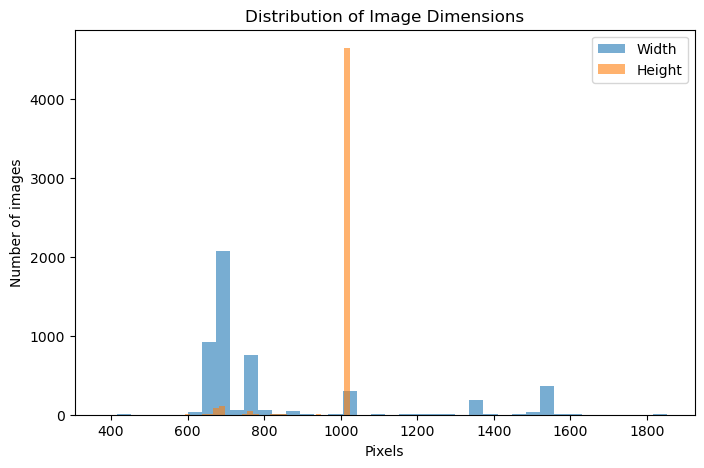

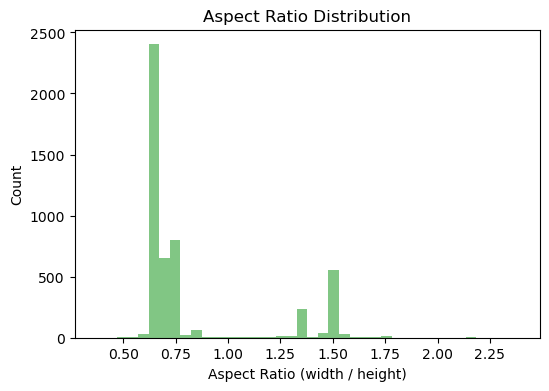

In [35]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8,5))
plt.hist(size_df["width"].dropna(), bins=40, alpha=0.6, label="Width")
plt.hist(size_df["height"].dropna(), bins=40, alpha=0.6, label="Height")
plt.xlabel("Pixels")
plt.ylabel("Number of images")
plt.title("Distribution of Image Dimensions")
plt.legend()
plt.show()

plt.figure(figsize=(6,4))
plt.hist(size_df["aspect_ratio"].dropna(), bins=40, color="#4CAF50", alpha=0.7)
plt.xlabel("Aspect Ratio (width / height)")
plt.ylabel("Count")
plt.title("Aspect Ratio Distribution")
plt.show()


## 11. Image Size Analysis - Part 3
Visualize image dimension and aspect ratio distributions


Shows clearly which species are “herbarium-only” vs “paired” in your own data, not just from the provided lists

In [39]:
import pandas as pd
from pathlib import Path


OUT_DIR   = DATA_ROOT / "processed"

train_csv = OUT_DIR / "train_v2.csv"  # or "train.csv"

df = pd.read_csv(train_csv)

# normalize domain labels
df["domain"] = df["domain"].astype(str).str.lower()
df["domain_norm"] = df["domain"].replace({"photo": "field"})  # treat "photo" as field


## 12. Per-Class Domain Statistics - Part 1
Load training data and normalize domain labels


In [40]:
# Count images per (label_idx, species_name, domain_norm)
grouped = (
    df.groupby(["label_idx", "species_name", "domain_norm"])
      .size()
      .reset_index(name="count")
)

# Pivot to columns: herbarium, field
pivot = grouped.pivot_table(
    index=["label_idx", "species_name"],
    columns="domain_norm",
    values="count",
    fill_value=0
).reset_index()

# Ensure columns exist even if some domains are missing
if "herbarium" not in pivot.columns:
    pivot["herbarium"] = 0
if "field" not in pivot.columns:
    pivot["field"] = 0

pivot = pivot.rename(columns={
    "herbarium": "n_herbarium",
    "field": "n_field"
})

pivot["total"]    = pivot["n_herbarium"] + pivot["n_field"]
pivot["has_pair"] = (pivot["n_herbarium"] > 0) & (pivot["n_field"] > 0)

pivot = pivot.sort_values("label_idx").reset_index(drop=True)
pivot.head()


domain_norm,label_idx,species_name,n_field,n_herbarium,total,has_pair
0,0,Anacardium occidentale L.,0.0,26.0,26.0,False
1,1,Mangifera indica L.,17.0,23.0,40.0,True
2,2,Spondias mombin L.,13.0,27.0,40.0,True
3,3,Tapirira guianensis Aubl.,13.0,27.0,40.0,True
4,4,Annona ambotay Aubl.,0.0,40.0,40.0,False


## 12. Per-Class Domain Statistics - Part 2
Count herbarium vs field images per species and create pivot table


In [41]:
out_path = OUT_DIR / "per_class_domain_stats.csv"
pivot.to_csv(out_path, index=False)
print("Saved per-class per-domain stats to:", out_path)

print("\nSummary:")
print("Total species:", pivot["label_idx"].nunique())
print("Species with BOTH herbarium + field:", pivot["has_pair"].sum())
print("Species herbarium-only:", ((pivot["n_herbarium"] > 0) & (pivot["n_field"] == 0)).sum())
print("Species field-only (unlikely):", ((pivot["n_herbarium"] == 0) & (pivot["n_field"] > 0)).sum())


Saved per-class per-domain stats to: D:\AML\AML dataset\Herbarium_Field dataset\AML_project_herbarium_dataset\processed\per_class_domain_stats.csv

Summary:
Total species: 100
Species with BOTH herbarium + field: 60
Species herbarium-only: 40
Species field-only (unlikely): 0


## 12. Per-Class Domain Statistics - Part 3
Save per-class domain statistics and display summary


In [ ]:
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image
import pandas as pd

IMG_SIZE = 224

IMAGENET_MEAN = [0.485, 0.456, 0.406]
IMAGENET_STD  = [0.229, 0.224, 0.225]

# 🔹 Herbarium: mild aug — paper-like, mostly flat
herbarium_train_tf = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.RandomRotation(degrees=5),  # small rotation
    transforms.ColorJitter(
        brightness=0.1,
        contrast=0.1,
        saturation=0.05,
        hue=0.02
    ),
    transforms.ToTensor(),
    transforms.Normalize(IMAGENET_MEAN, IMAGENET_STD),
])

# 🔹 Field/photo: stronger aug — outdoor variability
field_train_tf = transforms.Compose([
    transforms.RandomResizedCrop(IMG_SIZE, scale=(0.8, 1.0)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(degrees=10),
    transforms.ColorJitter(
        brightness=0.3,
        contrast=0.3,
        saturation=0.3,
        hue=0.04
    ),
    transforms.ToTensor(),
    transforms.Normalize(IMAGENET_MEAN, IMAGENET_STD),
])

# 🔹 Validation / test: same for all domains, no augmentation
val_test_tf = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize(IMAGENET_MEAN, IMAGENET_STD),
])


## 13. PyTorch Dataset and DataLoader - Part 1
Define domain-specific data augmentation transforms (herbarium vs field)


In [ ]:
class PlantDomainAugDataset(Dataset):
    def __init__(
        self,
        csv_file,
        split="train",
        herbarium_transform=None,
        field_transform=None,
        val_test_transform=None,
        with_labels=True,
    ):
        self.df = pd.read_csv(csv_file)
        self.split = split  # "train", "val", or "test"
        self.herbarium_tf = herbarium_transform
        self.field_tf = field_transform
        self.val_test_tf = val_test_transform
        self.with_labels = with_labels

        # normalize domain text
        if "domain" in self.df.columns:
            self.df["domain"] = self.df["domain"].astype(str).str.lower()

        if self.with_labels and "label_idx" not in self.df.columns:
            raise ValueError("CSV must contain 'label_idx' for training/validation.")

    def __len__(self):
        return len(self.df)

    def _choose_transform(self, domain: str):
        # For val/test: always use common transform
        if self.split in ["val", "test"]:
            return self.val_test_tf

        # For train: domain-specific
        if domain == "herbarium":
            return self.herbarium_tf or self.field_tf or self.val_test_tf
        if domain in ["field", "photo"]:
            return self.field_tf or self.herbarium_tf or self.val_test_tf
        # fallback
        return self.field_tf or self.herbarium_tf or self.val_test_tf

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        img_path = row["abs_path"]
        img = Image.open(img_path).convert("RGB")

        domain = row.get("domain", "field").lower()
        transform = self._choose_transform(domain)
        if transform is not None:
            img = transform(img)

        if self.with_labels:
            label = int(row["label_idx"])
            return img, label, domain
        else:
            return img, img_path, domain


## 13. PyTorch Dataset and DataLoader - Part 2
Create custom Dataset class with domain-aware augmentation (example)


In [ ]:
from pathlib import Path

DATA_ROOT = Path("/content/data")
OUT_DIR   = DATA_ROOT / "processed"

train_csv = OUT_DIR / "train_v2.csv"  # or "train.csv"
val_csv   = OUT_DIR / "val_v2.csv"    # or "val.csv"
test_csv  = OUT_DIR / "test.csv"

BATCH_SIZE = 32

train_dataset = PlantDomainAugDataset(
    csv_file=train_csv,
    split="train",
    herbarium_transform=herbarium_train_tf,
    field_transform=field_train_tf,
    val_test_transform=val_test_tf,
    with_labels=True,
)

val_dataset = PlantDomainAugDataset(
    csv_file=val_csv,
    split="val",
    herbarium_transform=herbarium_train_tf,
    field_transform=field_train_tf,
    val_test_transform=val_test_tf,
    with_labels=True,
)

test_dataset = PlantDomainAugDataset(
    csv_file=test_csv,
    split="test",
    herbarium_transform=herbarium_train_tf,
    field_transform=field_train_tf,
    val_test_transform=val_test_tf,
    with_labels=False,
)

from torch.utils.data import DataLoader

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=2, pin_memory=True)
val_loader   = DataLoader(val_dataset,   batch_size=BATCH_SIZE, shuffle=False, num_workers=2, pin_memory=True)
test_loader  = DataLoader(test_dataset,  batch_size=BATCH_SIZE, shuffle=False, num_workers=2, pin_memory=True)

# quick sanity check
imgs, labels, domains = next(iter(train_loader))
print("Batch:", imgs.shape, "labels:", labels[:5].tolist(), "domains:", list(domains[:5]))
